#Setup

In [ ]:
!pip install ucimlrepo

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, f1_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import joblib

# Display settings — why?
pd.set_option("display.max_columns", 200)   # So that when we print tables, pandas shows up to 200 columns
np.set_printoptions(suppress=True)          # Prevents numpy from printing very small numbers in "scientific notation"

#Load Data

In [ ]:
# Fetch dataset directly from UCI repository
cardiotocography = fetch_ucirepo(id=193)

# Features and targets
X = cardiotocography.data.features.copy()
y_all = cardiotocography.data.targets.copy()
y_nsp = y_all["NSP"].astype(int)   # 3-class
y_cls = y_all["CLASS"].astype(int) # 10-class

# Metadata and variables (for documentation & understanding dataset)
print("\n=== Metadata ===")
print(cardiotocography.metadata)

print("\n=== Variables (features + targets) ===")
print(cardiotocography.variables)



=== Metadata ===
{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs we

#Explore Data with Histograms

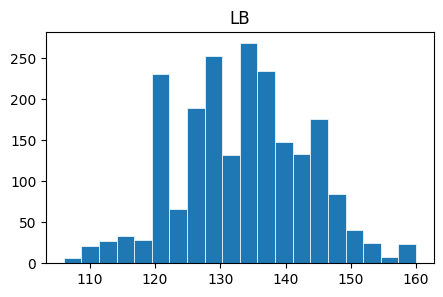

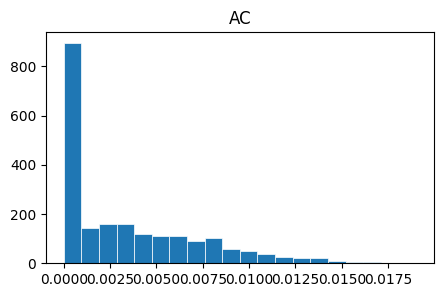

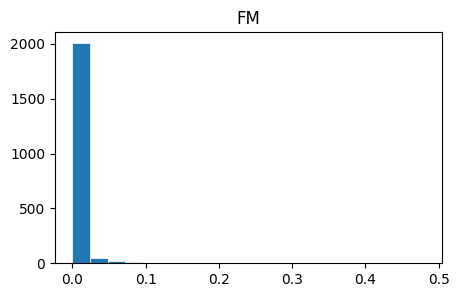

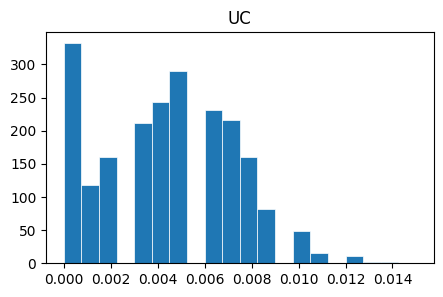

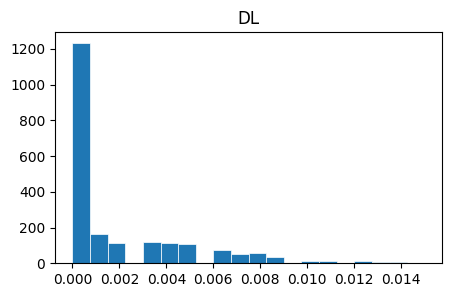

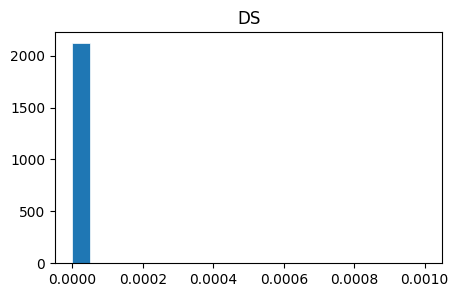

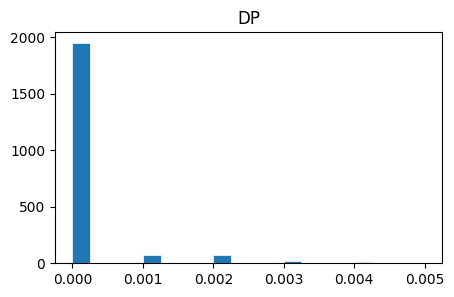

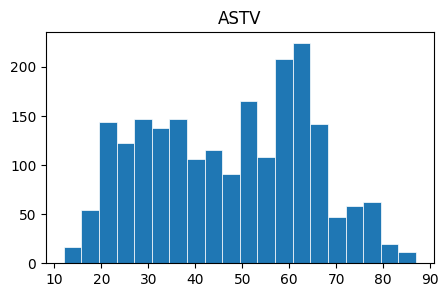

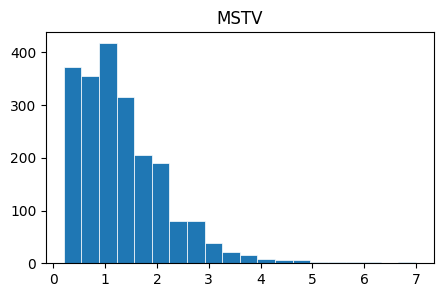

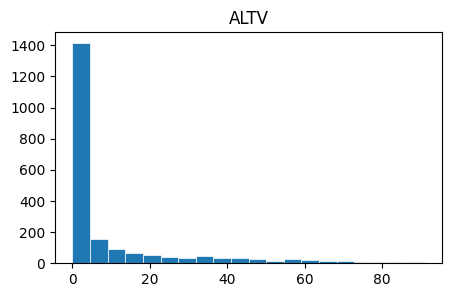

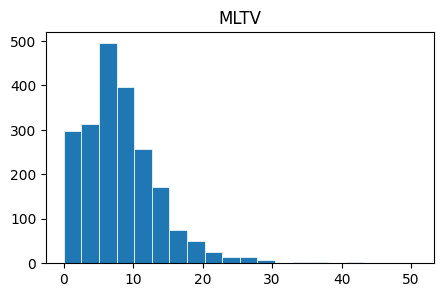

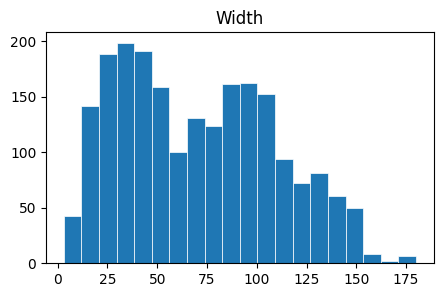

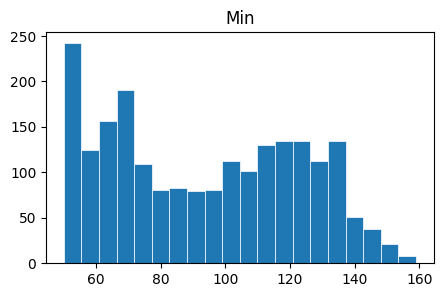

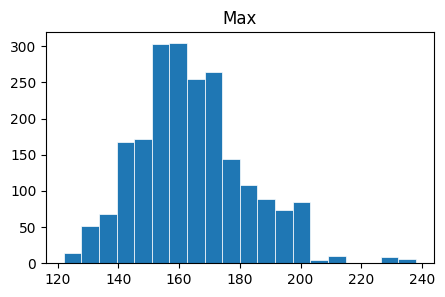

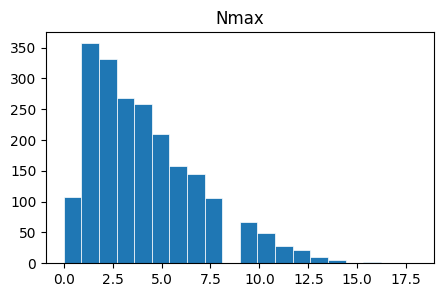

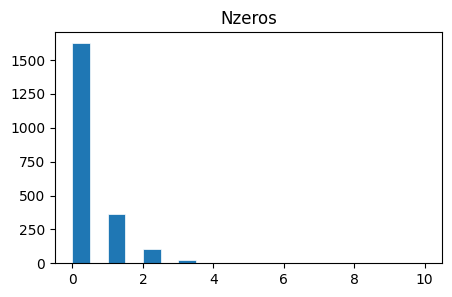

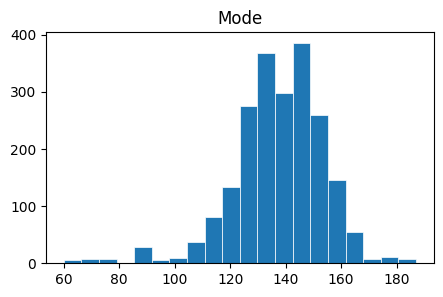

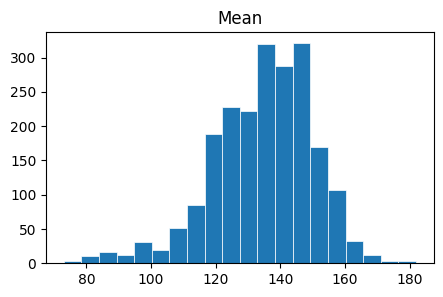

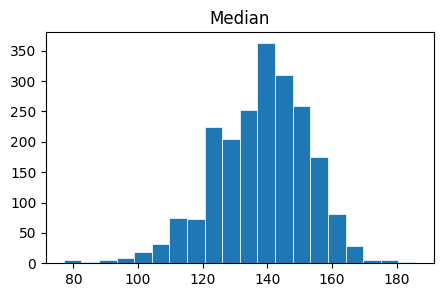

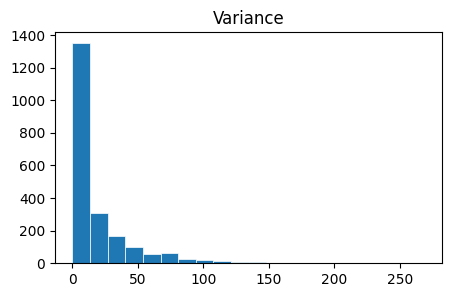

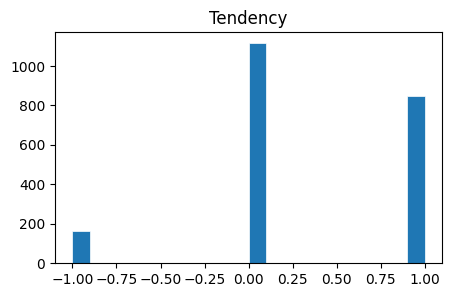

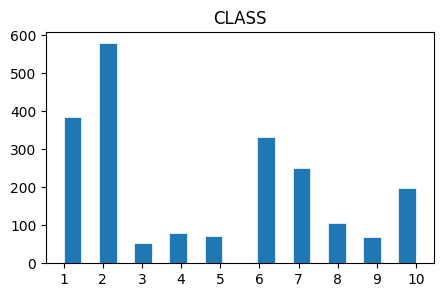

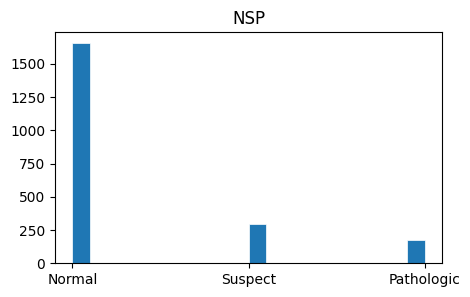

Min DS: 0.0
Max DS: 0.001


In [ ]:
# Plot histograms for every variable (features + targets)
columns = cardiotocography.variables['name']

for column in columns:
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3)

    if column not in ['NSP', 'CLASS']:
        data = cardiotocography.data.features[column]
    else:
        data = cardiotocography.data.targets[column]

    ax.hist(data, bins=20, linewidth=0.5, edgecolor="white")

    # Custom x-ticks for categorical targets
    if column == 'NSP':
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['Normal', 'Suspect', 'Pathologic'])
    elif column == 'CLASS':
        ax.set_xticks(np.arange(1, 11))
    elif column == 'TENDENCY':
        ax.set_xticks(np.arange(-1, 2))

    ax.set_title(column)
    plt.show()

# Example checks for feature ranges
print("Min DS:", cardiotocography.data.features['DS'].min())
print("Max DS:", cardiotocography.data.features['DS'].max())


#Feature–Target Relationships (Spearman correlation)




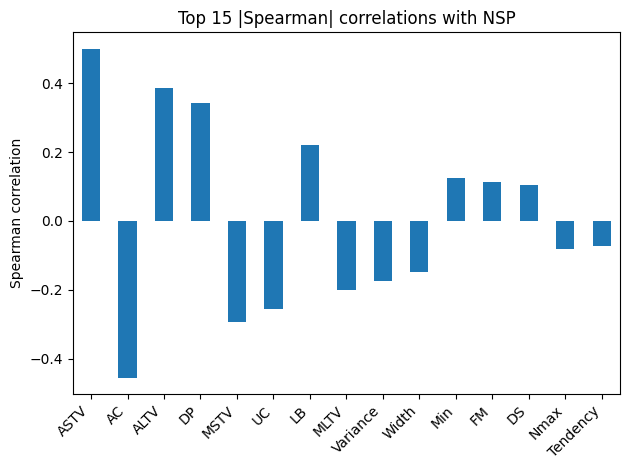

In [ ]:
# Correlation of each feature vs NSP. Spearman is good for ordinal target (1<2<3)
spearman_vs_nsp = X.apply(lambda col: col.corr(y_nsp, method="spearman"))
spearman_sorted = spearman_vs_nsp.reindex(spearman_vs_nsp.abs().sort_values(ascending=False).index)

# keep figure readable
top_k = 15
spearman_sorted.head(top_k).plot(kind="bar")
plt.title(f"Top {top_k} |Spearman| correlations with NSP")
plt.ylabel("Spearman correlation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


#Train/Test Split

In [ ]:
# 80/20 split, stratified so each set has all classes in proportion
Xtr_nsp, Xte_nsp, ytr_nsp, yte_nsp = train_test_split(X, y_nsp, test_size=0.2, stratify=y_nsp)
Xtr_cls, Xte_cls, ytr_cls, yte_cls = train_test_split(X, y_cls, test_size=0.2, stratify=y_cls)


#Evaluation Function

In [ ]:
def evaluate_model(name, model, Xtr, ytr, Xte, yte, display_labels=None):
    # Latency
    t0 = time.perf_counter(); model.fit(Xtr, ytr); fit_s = time.perf_counter() - t0
    t1 = time.perf_counter(); ypred = model.predict(Xte); pred_ms = (time.perf_counter() - t1) * 1000

    # Metrics for imbalance
    ba  = balanced_accuracy_score(yte, ypred)
    f1m = f1_score(yte, ypred, average="macro")

    print(f"\n{name}")
    print(f"Balanced Accuracy: {ba:.4f} | Macro F1: {f1m:.4f} | fit={fit_s:.3f}s | predict={pred_ms:.1f}ms")
    print(classification_report(yte, ypred, target_names=display_labels) if display_labels else
          classification_report(yte, ypred))

    cm = confusion_matrix(yte, ypred)
    ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(cmap="Blues")
    plt.title(f"{name} – Confusion Matrix"); plt.show()

    return {"ba":ba, "f1":f1m, "fit_s":fit_s, "pred_ms":pred_ms}, ypred, model


#NSP Models (Decision Tree, Random Forest, Gradient Boosting)


Decision Tree (NSP)
Balanced Accuracy: 0.7955 | Macro F1: 0.7965 | fit=0.029s | predict=2.7ms
              precision    recall  f1-score   support

      Normal       0.93      0.93      0.93       332
     Suspect       0.61      0.63      0.62        59
  Pathologic       0.85      0.83      0.84        35

    accuracy                           0.88       426
   macro avg       0.80      0.80      0.80       426
weighted avg       0.88      0.88      0.88       426



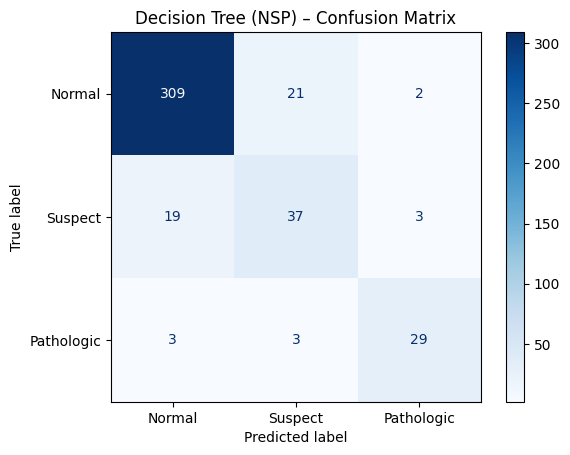


Random Forest (NSP)
Balanced Accuracy: 0.8731 | Macro F1: 0.8970 | fit=1.441s | predict=91.6ms
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97       332
     Suspect       0.88      0.75      0.81        59
  Pathologic       0.94      0.89      0.91        35

    accuracy                           0.95       426
   macro avg       0.93      0.87      0.90       426
weighted avg       0.94      0.95      0.94       426



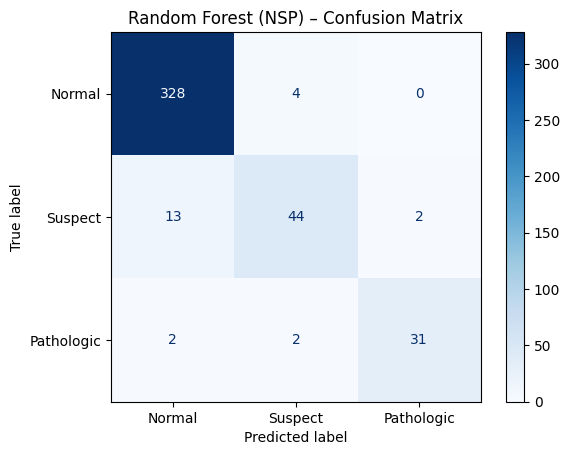

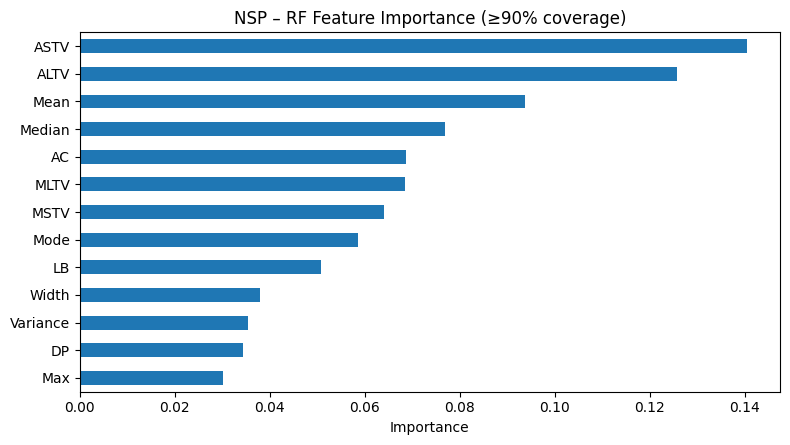


HistGradientBoosting (NSP)
Balanced Accuracy: 0.9109 | Macro F1: 0.9226 | fit=2.348s | predict=101.2ms
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       332
     Suspect       0.89      0.83      0.86        59
  Pathologic       0.94      0.91      0.93        35

    accuracy                           0.96       426
   macro avg       0.94      0.91      0.92       426
weighted avg       0.96      0.96      0.96       426



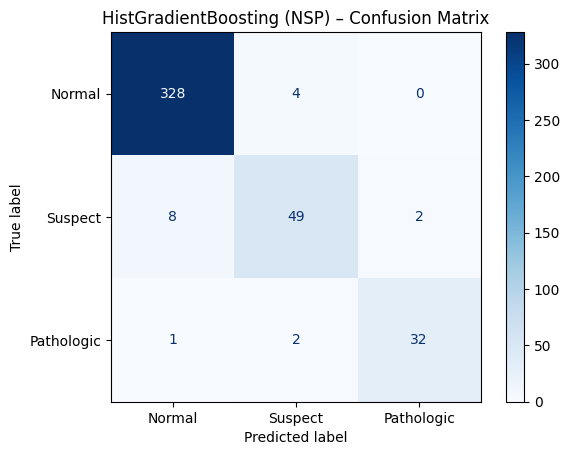

In [ ]:
# Decision Tree
dt_nsp = DecisionTreeClassifier(class_weight="balanced")
dtN_metrics, dtN_pred, dtN_fit = evaluate_model("Decision Tree (NSP)", dt_nsp,
    Xtr_nsp, ytr_nsp, Xte_nsp, yte_nsp, ["Normal","Suspect","Pathologic"])

# Random Forest
rf_nsp = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1)
rfN_metrics, rfN_pred, rfN_fit = evaluate_model("Random Forest (NSP)", rf_nsp,
    Xtr_nsp, ytr_nsp, Xte_nsp, yte_nsp, ["Normal","Suspect","Pathologic"])

# Explainability: ≥90% of RF importance
imp = pd.Series(rfN_fit.feature_importances_, index=X.columns).sort_values(ascending=False)
cum = (imp/imp.sum()).cumsum()
rf_keep = imp.loc[cum <= 0.90] if not imp.empty else imp.head(1)
rf_keep.sort_values().plot(kind="barh", figsize=(8, max(3, 0.35*len(rf_keep))))
plt.title("NSP – RF Feature Importance (≥90% coverage)")
plt.xlabel("Importance"); plt.tight_layout(); plt.show()

# Gradient Boosting
hgb_nsp = HistGradientBoostingClassifier()
hgbN_metrics, hgbN_pred, hgbN_fit = evaluate_model("HistGradientBoosting (NSP)", hgb_nsp,
    Xtr_nsp, ytr_nsp, Xte_nsp, yte_nsp, ["Normal","Suspect","Pathologic"])


#CLASS Models (Decision Tree, RF, HGB)


Decision Tree (CLASS)
Balanced Accuracy: 0.7793 | Macro F1: 0.7649 | fit=0.073s | predict=4.5ms
              precision    recall  f1-score   support

           1       0.77      0.83      0.80        77
           2       0.90      0.77      0.83       116
           3       0.50      0.55      0.52        11
           4       0.55      0.75      0.63        16
           5       0.56      0.71      0.62        14
           6       0.83      0.88      0.86        67
           7       0.84      0.84      0.84        51
           8       0.89      0.81      0.85        21
           9       0.92      0.86      0.89        14
          10       0.82      0.79      0.81        39

    accuracy                           0.81       426
   macro avg       0.76      0.78      0.76       426
weighted avg       0.82      0.81      0.81       426



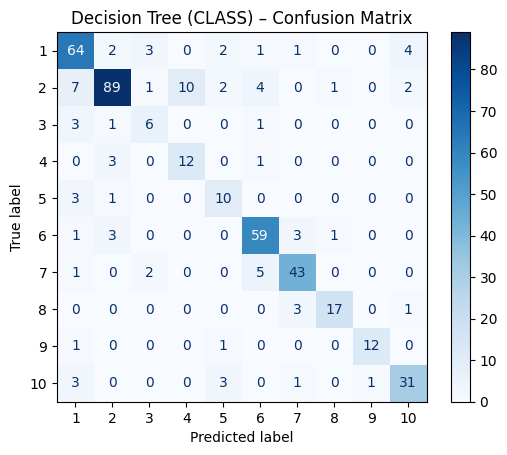


Random Forest (CLASS)
Balanced Accuracy: 0.8458 | Macro F1: 0.8522 | fit=2.012s | predict=114.3ms
              precision    recall  f1-score   support

           1       0.85      0.86      0.85        77
           2       0.93      0.84      0.89       116
           3       0.73      0.73      0.73        11
           4       0.86      0.75      0.80        16
           5       0.85      0.79      0.81        14
           6       0.80      0.91      0.85        67
           7       0.85      0.92      0.89        51
           8       1.00      0.81      0.89        21
           9       0.93      0.93      0.93        14
          10       0.84      0.92      0.88        39

    accuracy                           0.87       426
   macro avg       0.86      0.85      0.85       426
weighted avg       0.87      0.87      0.87       426



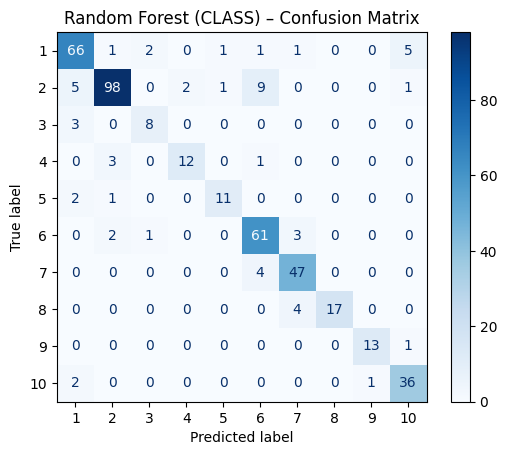

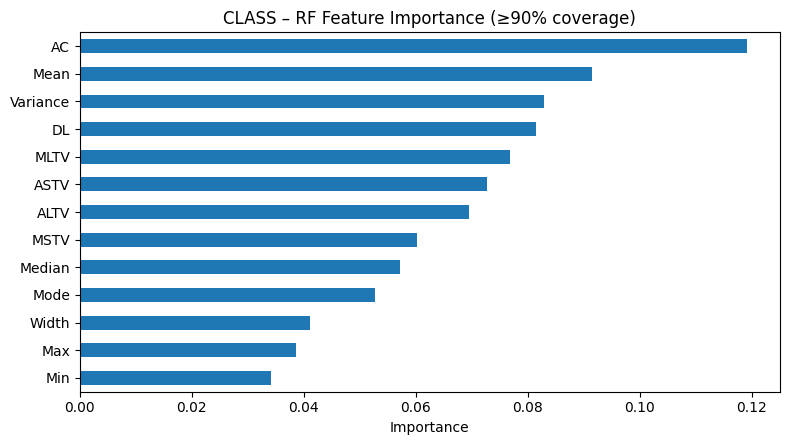


HistGradientBoosting (CLASS)
Balanced Accuracy: 0.8569 | Macro F1: 0.8704 | fit=2.958s | predict=62.9ms
              precision    recall  f1-score   support

           1       0.82      0.87      0.84        77
           2       0.96      0.90      0.93       116
           3       0.82      0.82      0.82        11
           4       0.93      0.88      0.90        16
           5       0.89      0.57      0.70        14
           6       0.86      0.96      0.91        67
           7       0.87      0.92      0.90        51
           8       1.00      0.81      0.89        21
           9       0.93      0.93      0.93        14
          10       0.86      0.92      0.89        39

    accuracy                           0.89       426
   macro avg       0.89      0.86      0.87       426
weighted avg       0.89      0.89      0.89       426



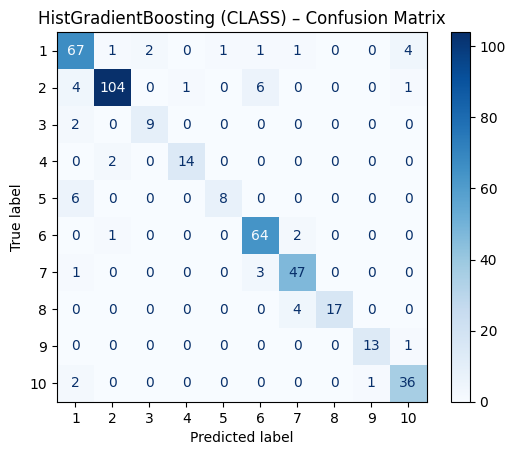

In [ ]:
labels_cls = [str(i) for i in sorted(y_cls.unique())]

# Decision Tree
dt_cls = DecisionTreeClassifier(class_weight="balanced")
dtC_metrics, dtC_pred, dtC_fit = evaluate_model("Decision Tree (CLASS)", dt_cls,
    Xtr_cls, ytr_cls, Xte_cls, yte_cls, labels_cls)

# Random Forest
rf_cls = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1)
rfC_metrics, rfC_pred, rfC_fit = evaluate_model("Random Forest (CLASS)", rf_cls,
    Xtr_cls, ytr_cls, Xte_cls, yte_cls, labels_cls)

# Explainability: ≥90% of RF importance
impC = pd.Series(rfC_fit.feature_importances_, index=X.columns).sort_values(ascending=False)
cumC = (impC/impC.sum()).cumsum()
rfC_keep = impC.loc[cumC <= 0.90] if not impC.empty else impC.head(1)
rfC_keep.sort_values().plot(kind="barh", figsize=(8, max(3, 0.35*len(rfC_keep))))
plt.title("CLASS – RF Feature Importance (≥90% coverage)")
plt.xlabel("Importance"); plt.tight_layout(); plt.show()

# Gradient Boosting
hgb_cls = HistGradientBoostingClassifier()
hgbC_metrics, hgbC_pred, hgbC_fit = evaluate_model("HistGradientBoosting (CLASS)", hgb_cls,
    Xtr_cls, ytr_cls, Xte_cls, yte_cls, labels_cls)


#Cross-Validation

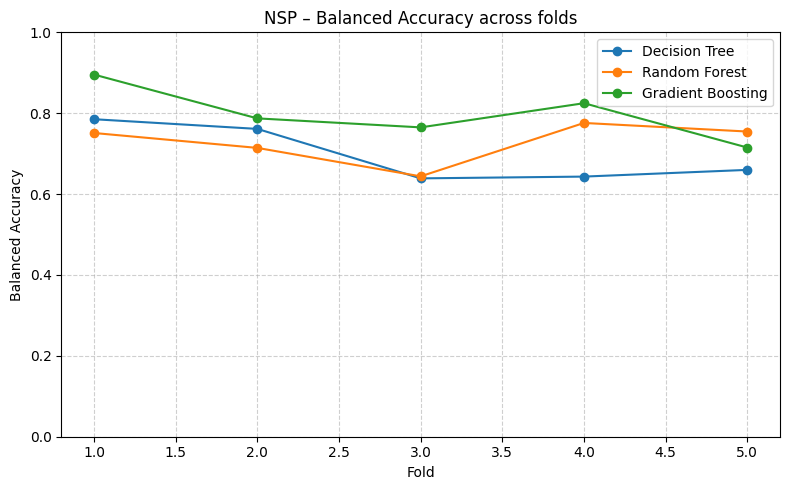

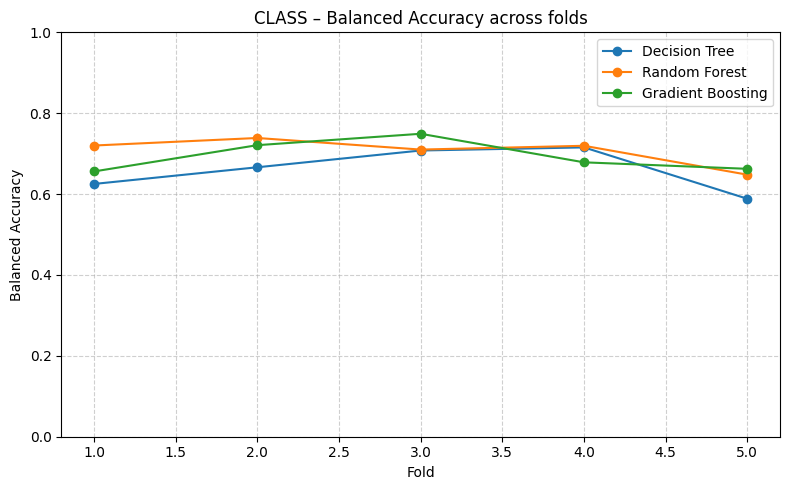

In [ ]:
cv = StratifiedKFold(n_splits=5)

def per_fold(model, X, y, label):
    ba = cross_val_score(model, X, y, scoring="balanced_accuracy", cv=cv, n_jobs=-1)
    f1 = cross_val_score(model, X, y, scoring="f1_macro", cv=cv, n_jobs=-1)
    return pd.DataFrame({"Model":[label]*len(ba),"Fold":range(1,len(ba)+1),"BalancedAcc":ba,"MacroF1":f1})

cv_nsp = pd.concat([
    per_fold(DecisionTreeClassifier(class_weight="balanced"), X, y_nsp, "Decision Tree"),
    per_fold(RandomForestClassifier(n_estimators=200,class_weight="balanced",n_jobs=-1), X, y_nsp, "Random Forest"),
    per_fold(HistGradientBoostingClassifier(), X, y_nsp, "Gradient Boosting")
])

cv_cls = pd.concat([
    per_fold(DecisionTreeClassifier(class_weight="balanced"), X, y_cls, "Decision Tree"),
    per_fold(RandomForestClassifier(n_estimators=200,class_weight="balanced",n_jobs=-1), X, y_cls, "Random Forest"),
    per_fold(HistGradientBoostingClassifier(), X, y_cls, "Gradient Boosting")
])

# Plots
for df,label in [(cv_nsp,"NSP"),(cv_cls,"CLASS")]:
    plt.figure(figsize=(8,5))
    for name in df["Model"].unique():
        s=df[df["Model"]==name]
        plt.plot(s["Fold"], s["BalancedAcc"], marker="o", label=name)
    plt.ylim(0,1); plt.grid(True, ls="--", alpha=0.6)
    plt.title(f"{label} – Balanced Accuracy across folds"); plt.xlabel("Fold"); plt.ylabel("Balanced Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()


#Compare Models (Bar)

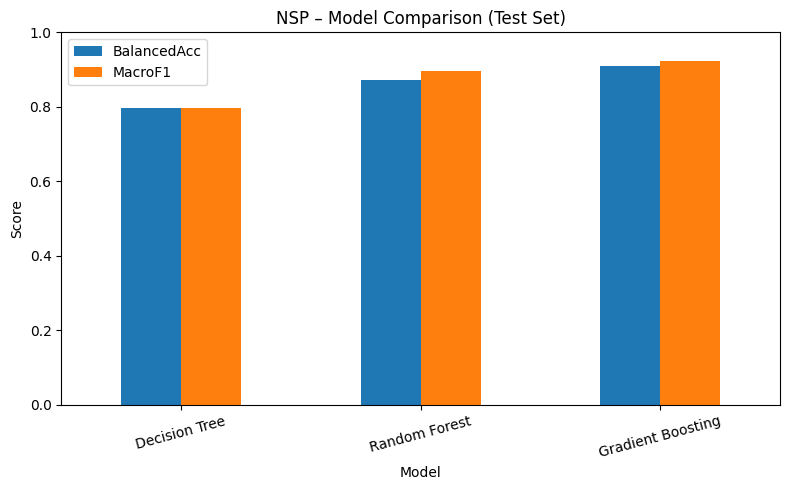

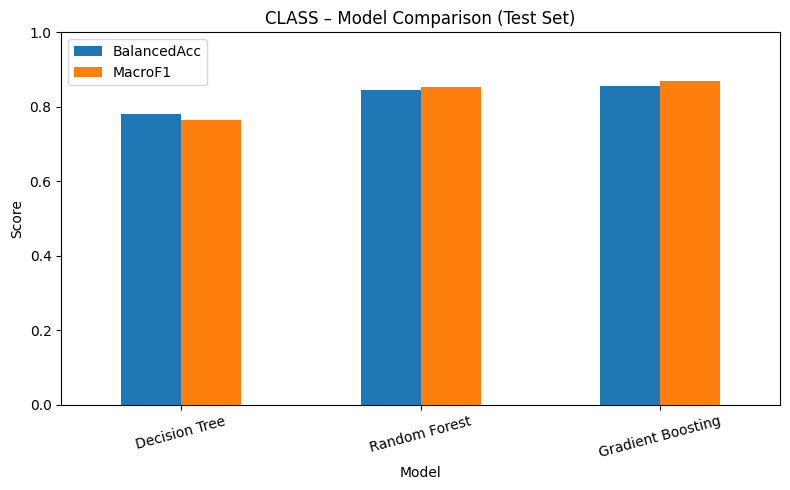

In [ ]:
compare_nsp = pd.DataFrame({
    "Model":["Decision Tree","Random Forest","Gradient Boosting"],
    "BalancedAcc":[dtN_metrics["ba"], rfN_metrics["ba"], hgbN_metrics["ba"]],
    "MacroF1":[dtN_metrics["f1"], rfN_metrics["f1"], hgbN_metrics["f1"]],
})
compare_cls = pd.DataFrame({
    "Model":["Decision Tree","Random Forest","Gradient Boosting"],
    "BalancedAcc":[dtC_metrics["ba"], rfC_metrics["ba"], hgbC_metrics["ba"]],
    "MacroF1":[dtC_metrics["f1"], rfC_metrics["f1"], hgbC_metrics["f1"]],
})

for df,label in [(compare_nsp,"NSP"),(compare_cls,"CLASS")]:
    df.set_index("Model").plot(kind="bar", figsize=(8,5))
    plt.title(f"{label} – Model Comparison (Test Set)")
    plt.ylim(0,1); plt.ylabel("Score"); plt.xticks(rotation=15)
    plt.tight_layout(); plt.show()


#Save Best Models & Predict Functions

In [ ]:
def pick_best(metrics_dt, metrics_rf, metrics_hgb):
    cands={"DT":metrics_dt,"RF":metrics_rf,"HGB":metrics_hgb}
    return sorted(cands.items(), key=lambda kv:(kv[1]["ba"],kv[1]["f1"]), reverse=True)[0][0]

win_nsp = pick_best(dtN_metrics, rfN_metrics, hgbN_metrics)
win_cls = pick_best(dtC_metrics, rfC_metrics, hgbC_metrics)
print("Chosen NSP model:", win_nsp, "| Chosen CLASS model:", win_cls)

fit_map_nsp={"DT":dtN_fit,"RF":rfN_fit,"HGB":hgbN_fit}
fit_map_cls={"DT":dtC_fit,"RF":rfC_fit,"HGB":hgbC_fit}
joblib.dump(fit_map_nsp[win_nsp], f"{win_nsp}_NSP.pkl")
joblib.dump(fit_map_cls[win_cls], f"{win_cls}_CLASS.pkl")

def predict_nsp(new_df):
    model = joblib.load(f"{win_nsp}_NSP.pkl")
    preds = model.predict(new_df[X.columns])
    return pd.Series(preds).map({1:"Normal",2:"Suspect",3:"Pathologic"})

def predict_class(new_df):
    model = joblib.load(f"{win_cls}_CLASS.pkl")
    preds = model.predict(new_df[X.columns])
    return pd.Series(preds)  # CLASS is numeric 1..10

# Mini demo
# NSP demo: show predictions vs true labels
print("\nNSP Demo (first 5 test samples):")
nsp_demo_preds = predict_nsp(Xte_nsp.head(5))      # model predictions
nsp_demo_truth = yte_nsp.head(5).map({1:"Normal", 2:"Suspect", 3:"Pathologic"})  # true labels
nsp_demo = pd.DataFrame({"True Label": nsp_demo_truth.values,
                         "Predicted Label": nsp_demo_preds.values})
print(nsp_demo)

# CLASS demo: show predictions vs true labels
print("\nCLASS Demo (first 5 test samples):")
cls_demo_preds = predict_class(Xte_cls.head(5))    # model predictions
cls_demo_truth = yte_cls.head(5)                   # true labels (1..10)
cls_demo = pd.DataFrame({"True Label": cls_demo_truth.values,
                         "Predicted Label": cls_demo_preds.values})
print(cls_demo)


Chosen NSP model: HGB | Chosen CLASS model: HGB

NSP Demo (first 5 test samples):
   True Label Predicted Label
0      Normal          Normal
1  Pathologic      Pathologic
2      Normal          Normal
3      Normal          Normal
4      Normal          Normal

CLASS Demo (first 5 test samples):
   True Label  Predicted Label
0           6                7
1           7                7
2           2                2
3           2                2
4           7                6
